In [1]:
from glob import glob
import os.path as op
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import nibabel as nib
from nibabel.streamlines import load as load_trk
import dipy.tracking.streamline as dts
import dipy.tracking.utils as dtu
from skimage.transform import resize
from scipy.ndimage.morphology import binary_dilation
import dipy.data as dpd

In [3]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D

Using TensorFlow backend.


In [4]:
import bundlenet as bn

In [5]:
dpd.fetch_bundles_2_subjects()

Data size is approximately 234MB
Dataset is already in place. If you want to fetch it again please first remove the folder /home/ariel/.dipy/exp_bundles_and_maps 


({'bundles_2_subjects.tar.gz': ('https://digital.lib.washington.edu/researchworks/bitstream/handle/1773/38477/bundles_2_subjects.tar.gz',
   '97756fbef11ce2df31f1bedf1fc7aac7')},
 '/home/ariel/.dipy/exp_bundles_and_maps')

In [6]:
ls /home/ariel/.dipy/exp_bundles_and_maps/bundles_2_subjects/subj_1/bundles/

bundles_af.left.trk   bundles_cg.left.trk     bundles_mdlf.right.trk
bundles_af.right.trk  bundles_cg.right.trk    bundles_slf1.left.trk
bundles_cc_1.trk      bundles_cst.left.trk    bundles_slf1.right.trk
bundles_cc_2.trk      bundles_cst.right.trk   bundles_slf2.left.trk
bundles_cc_3.trk      bundles_ifof.left.trk   bundles_slf2.right.trk
bundles_cc_4.trk      bundles_ifof.right.trk  bundles_slf_3.left.trk
bundles_cc_5.trk      bundles_ilf.left.trk    bundles_slf_3.right.trk
bundles_cc_6.trk      bundles_ilf.right.trk   bundles_uf.left.trk
bundles_cc_7.trk      bundles_mdlf.left.trk   bundles_uf.right.trk


In [7]:
bundle_files = glob('/home/ariel/.dipy/exp_bundles_and_maps/bundles_2_subjects/subj_1/bundles/*.trk')

In [8]:
t1_img = nib.load('/home/ariel/.dipy/exp_bundles_and_maps/bundles_2_subjects/subj_1/t1_warped.nii.gz')

In [9]:
n_streamlines = []
bundle_name = []
for fname in bundle_files:
    bundle_name.append(fname.split('/')[-1].split('bundles_')[-1].split('.trk')[0])
    streamlines = bn.read_sl(fname) 
    n_streamlines.append(len(streamlines))

In [10]:
bundle_name

['cg.left',
 'slf1.left',
 'ifof.left',
 'slf2.left',
 'cc_1',
 'cc_2',
 'cst.left',
 'af.left',
 'mdlf.left',
 'uf.right',
 'ilf.left',
 'slf_3.left',
 'cst.right',
 'cc_7',
 'cg.right',
 'cc_6',
 'slf1.right',
 'cc_5',
 'slf2.right',
 'slf_3.right',
 'ilf.right',
 'mdlf.right',
 'uf.left',
 'cc_4',
 'ifof.right',
 'cc_3',
 'af.right']

In [11]:
np.min(n_streamlines), len(n_streamlines)

(161, 27)

In [12]:
take_n_bundles = 27
take_n_sl = 160

In [13]:
if op.exists('./subject1_bundles.npz'):
    # Read it from file:
    loaded_from_file = np.load('./subject1_bundles.npz')
    labels_test = loaded_from_file['labels_test']
    labels_train = loaded_from_file['labels_train']
    data_test = loaded_from_file['data_test']
    data_train = loaded_from_file['data_train']
    data_valid = loaded_from_file['data_valid']
    labels_valid = loaded_from_file['labels_valid']
else:
    data_train, data_valid, data_test, labels_train, labels_valid, labels_test =\
    bn.partition_data(bundle_files, t1_img.shape, take_n_bundles, take_n_sl)    
    np.savez('./subject1_bundles', data_train=data_train, labels_train=labels_train,
                                   data_test=data_test, labels_test=labels_test, 
                                   data_valid=data_valid, labels_valid=labels_valid)

In [14]:
img_rows = 100
img_cols = 100
batch_size = 4
epochs = 12
num_classes = take_n_bundles
input_shape = (img_rows, img_cols, 1)

In [15]:
labels_train = keras.utils.to_categorical(labels_train-1, num_classes)
labels_valid = keras.utils.to_categorical(labels_valid-1, num_classes)
labels_test  = keras.utils.to_categorical(labels_test-1, num_classes)

In [16]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

In [17]:
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

In [18]:
training = model.fit(data_train, labels_train,
                     batch_size=batch_size,
                     epochs=epochs,
                     verbose=1,
                     validation_data=(data_valid, labels_valid))

Train on 2592 samples, validate on 864 samples
Epoch 1/12
2592/2592 [==============================] - 55s - loss: 0.6841 - acc: 0.8113 - val_loss: 0.2069 - val_acc: 0.9340
Epoch 2/12
2592/2592 [==============================] - 53s - loss: 0.2721 - acc: 0.9155 - val_loss: 0.1771 - val_acc: 0.9387
Epoch 3/12
2592/2592 [==============================] - 53s - loss: 0.2171 - acc: 0.9302 - val_loss: 0.1723 - val_acc: 0.9444
Epoch 4/12
2592/2592 [==============================] - 53s - loss: 0.1913 - acc: 0.9344 - val_loss: 0.1572 - val_acc: 0.9421
Epoch 5/12
2592/2592 [==============================] - 53s - loss: 0.1803 - acc: 0.9394 - val_loss: 0.1423 - val_acc: 0.9421
Epoch 6/12
2592/2592 [==============================] - 53s - loss: 0.1529 - acc: 0.9502 - val_loss: 0.1424 - val_acc: 0.9491
Epoch 7/12
2592/2592 [==============================] - 53s - loss: 0.1409 - acc: 0.9506 - val_loss: 0.1516 - val_acc: 0.9398
Epoch 8/12
2592/2592 [==============================] - 53s - loss: 0.1

In [19]:
score = model.evaluate(data_test, labels_test, verbose=0)

In [20]:
print(score)

[0.1492408281965254, 0.95370370370370372]


In [21]:
import matplotlib.pyplot as plt
%matplotlib inline

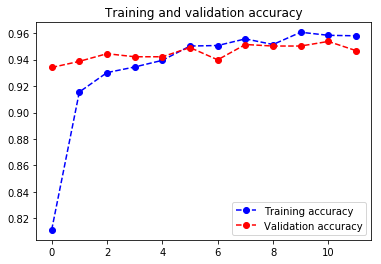

In [22]:
accuracy = training.history['acc']
val_accuracy = training.history['val_acc']
loss = training.history['loss']
val_loss = training.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo--', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'ro--', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

Cross-predict on *another subject*

In [23]:
sub2_bundle_files = glob('/home/ariel/.dipy/exp_bundles_and_maps/bundles_2_subjects/subj_2/bundles/*.trk')

In [24]:
sub2_t1_img = nib.load('/home/ariel/.dipy/exp_bundles_and_maps/bundles_2_subjects/subj_2/t1_warped.nii.gz')

In [27]:
n_streamlines = 0
for fname in sub2_bundle_files:
    streamlines = bn.read_sl(fname)
    n_streamlines += len(streamlines)

In [28]:
n_streamlines

57060

In [ ]:
data_sub2 = np.zeros((n_streamlines, 100, 100, 1))
actual_labels = np.zeros(n_streamlines, dtype=np.object)
ii = 0
for fname in sub2_bundle_files:
    bundle_name = fname.split('/')[-1].split('bundles_')[-1].split('.trk')[0]
    print(bundle_name)
    streamlines = bn.read_sl(fname)
    for sl in streamlines: 
        data_sub2[ii] = bn.reduce_sl(sl, t1_img.shape)
        ii += 1
        if not np.mod(ii, 100):
            print("ii = %s"%ii)
        actual_labels[ii] = bundle_name

np.savez('./subject2_bundles_all', data_sub2=data_sub2, actual_labels=np.array(actual_labels))

cg.left


/usr/local/lib/python3.4/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


ii = 100
ii = 200
ii = 300
ii = 400
ii = 500
ii = 600
ii = 700
ii = 800
ii = 900
ii = 1000
ii = 1100
ii = 1200
ii = 1300


In [ ]:
p = model.predict(projected[np.newaxis], batch_size=4)

In [ ]:
from sklearn.metrics import cohen_kappa_score